In [1]:
# ------------------------------
# Step 1: Import Required Libraries
# ------------------------------
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from dateutil.parser import parse

In [2]:
# ------------------------------
# Step 2: Fetch and Prepare Stock Data
# ------------------------------

# Set the date range
start_date = '2003-01-01'
end_date = '2021-12-31'

# Fetch data for Microsoft (MSFT)
msft = yf.Ticker('MSFT')
stock_data_msft = msft.history(start=start_date, end=end_date)

In [3]:
# Check if the stock data has multi-level columns
if isinstance(stock_data_msft.columns, pd.MultiIndex):
    print("Multi-level columns detected in stock data. Flattening columns...")
    stock_data_msft.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in stock_data_msft.columns]
else:
    print("Single-level columns detected in stock data.")

Single-level columns detected in stock data.


In [4]:
stock_data_msft.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-01-02 00:00:00-05:00,16.091723,16.537861,15.910191,16.528631,67025200,0.0,0.0
2003-01-03 00:00:00-05:00,16.488627,16.553240,16.270174,16.550163,55546800,0.0,0.0
2003-01-06 00:00:00-05:00,16.620930,16.993223,16.553239,16.851690,59456200,0.0,0.0
2003-01-07 00:00:00-05:00,16.897839,17.233211,16.823996,17.168598,80517400,0.0,0.0
2003-01-08 00:00:00-05:00,17.036302,17.091685,16.648625,16.688623,64566000,0.0,0.0


In [5]:
# Remove the timezone from the index
stock_data_msft.index = stock_data_msft.index.tz_localize(None)

In [6]:
# Check the current index of the stock_data DataFrame
print(stock_data_msft.index)
print(stock_data_msft.columns)

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='Date', length=4783, freq=None)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


In [7]:
# Reset index to make 'Date' a regular column
stock_data_msft.reset_index(inplace=True)

# Convert 'Date' column to datetime
stock_data_msft['Date'] = pd.to_datetime(stock_data_msft['Date'])

In [8]:
# ------------------------------
# Step 3: Load and Prepare News Data
# ------------------------------

# Load the cleaned business news data
news_data = pd.read_csv('cleaned_business_news_with_vader.csv')

# Convert 'publish_date' to datetime
news_data['publish_date'] = pd.to_datetime(news_data['publish_date'], errors='coerce')

# Check for missing values
print(news_data.isnull().sum())

publish_date      0
headline_text     0
compound_score    0
positive          0
neutral           0
negative          0
dtype: int64


In [9]:
news_data.head()

,publish_date,headline_text,compound_score,positive,neutral,negative
0,2003-02-19,businesses should prepare for terrorist attacks,-0.8225,0.000,0.345,0.655
1,2003-02-19,resource stocks boost all ords,0.4019,0.403,0.597,0.000
2,2003-02-19,shire offers assurances over finances,0.3400,0.375,0.625,0.000
3,2003-02-19,slow recovery predicted for aust economy,0.0000,0.000,1.000,0.000
4,2003-02-20,mud crab business on the move,0.0000,0.000,1.000,0.000


In [10]:
# ------------------------------
# Step 4: Merge Stock and News Data
# ------------------------------

# Merge stock data with news data on the Date and publish_date columns
merged_data_msft = pd.merge(stock_data_msft, news_data, left_on='Date', right_on='publish_date', how='inner')

# Fill missing sentiment scores with 0 (neutral)
merged_data_msft['compound_score'] = merged_data_msft['compound_score'].fillna(0)

In [11]:
merged_data_msft.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,publish_date,headline_text,compound_score,positive,neutral,negative
0,2003-02-19,15.322393,15.359433,14.921122,15.143365,46902700,0.08,0.0,2003-02-19,businesses should prepare for terrorist attacks,-0.8225,0.000,0.345,0.655
1,2003-02-19,15.322393,15.359433,14.921122,15.143365,46902700,0.08,0.0,2003-02-19,resource stocks boost all ords,0.4019,0.403,0.597,0.000
2,2003-02-19,15.322393,15.359433,14.921122,15.143365,46902700,0.08,0.0,2003-02-19,shire offers assurances over finances,0.3400,0.375,0.625,0.000
3,2003-02-19,15.322393,15.359433,14.921122,15.143365,46902700,0.08,0.0,2003-02-19,slow recovery predicted for aust economy,0.0000,0.000,1.000,0.000
4,2003-02-20,15.291526,15.353261,14.877908,14.902601,50897200,0.00,0.0,2003-02-20,mud crab business on the move,0.0000,0.000,1.000,0.000


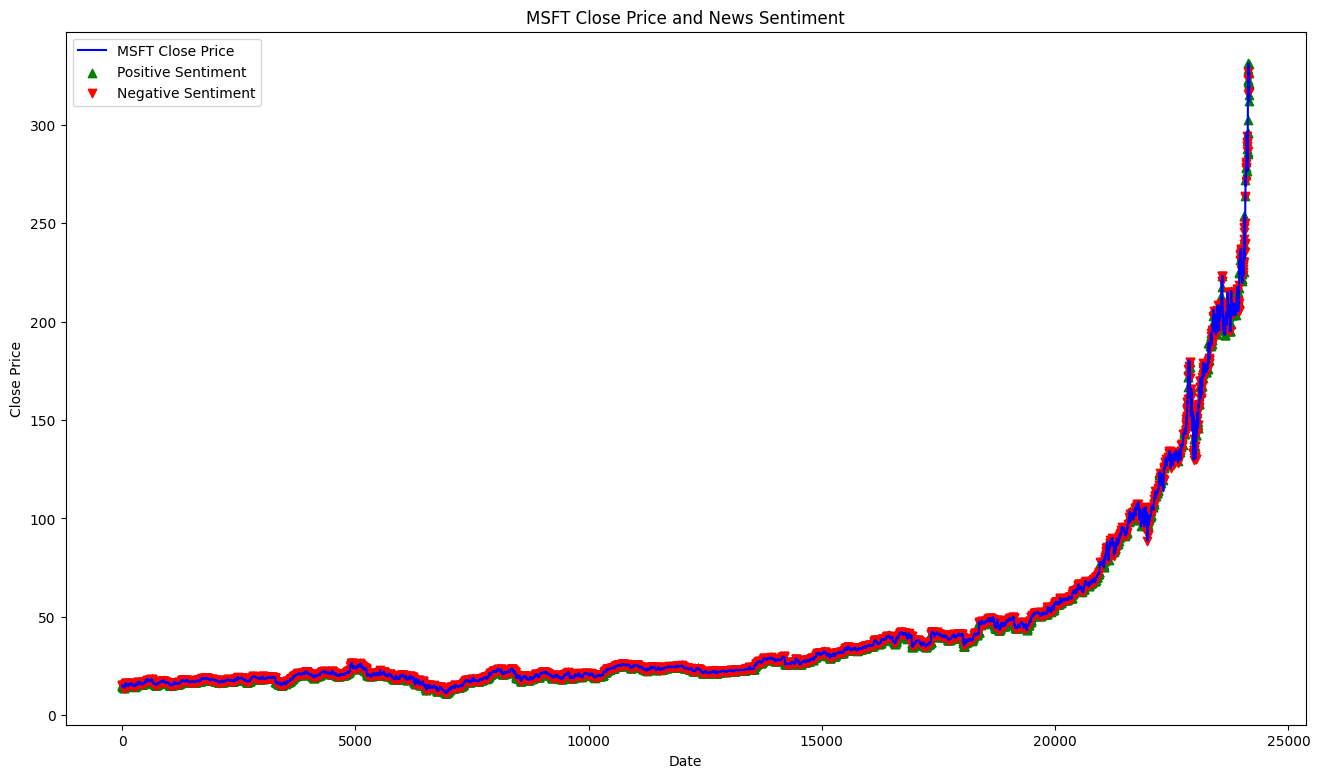

In [12]:
# ------------------------------
# Step 5: Visualize Data
# ------------------------------

plt.figure(figsize=(16, 9))
plt.plot(merged_data_msft['Close'], label='MSFT Close Price', color='blue')
plt.title('MSFT Close Price and News Sentiment')
plt.ylabel('Close Price')
plt.xlabel('Date')

# Highlight Positive Sentiment
plt.scatter(merged_data_msft.index[merged_data_msft['compound_score'] > 0], 
            merged_data_msft['Close'][merged_data_msft['compound_score'] > 0], 
            color='g', label='Positive Sentiment', marker='^')

# Highlight Negative Sentiment
plt.scatter(merged_data_msft.index[merged_data_msft['compound_score'] < 0], 
            merged_data_msft['Close'][merged_data_msft['compound_score'] < 0], 
            color='r', label='Negative Sentiment', marker='v')

plt.legend()
plt.show()

In [13]:
# ------------------------------
# Step 6: Data Preparation for Prophet
# ------------------------------

# Prepare the data for Prophet
prophet_data = merged_data_msft[['Date', 'Close', 'compound_score']].rename(columns={'Date': 'ds', 'Close': 'y'})

In [14]:
# ------------------------------
# Step 7: Split Data into Training and Testing Sets
# ------------------------------

# Split the data (80% training, 20% testing)
train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data[:train_size]
test_data = prophet_data[train_size:]

# Reset indices for train and test datasets
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


In [15]:
# ------------------------------
# Step 8: Build and Train the Facebook Prophet Model
# ------------------------------

# Initialize the Prophet model
model = Prophet()

# Adding the sentiment score as an external regressor
model.add_regressor('compound_score')

# Fit the Prophet model to the training data
model.fit(train_data)

13:27:24 - cmdstanpy - INFO - Chain [1] start processing
13:27:53 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# ------------------------------
# Step 9: Forecasting
# ------------------------------

# Create a dataframe for future dates
future = model.make_future_dataframe(periods=len(test_data))

In [17]:
# Merge future dataframe with sentiment data
future = pd.merge(future, prophet_data[['ds', 'compound_score']], on='ds', how='left')

In [18]:
# Fill missing sentiment values in the future data
future['compound_score'] = future['compound_score'].fillna(0)

In [19]:
# Make predictions
forecast = model.predict(future)

# Extract predictions for the test data period
forecast_test = forecast.iloc[-len(test_data):]

In [20]:
# ------------------------------
# Step 10: Model Evaluation
# ------------------------------

# Calculate evaluation metrics
actual_prices = test_data['y']
predicted_prices = forecast_test['yhat']

mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 2330.590193594304
Mean Absolute Error (MAE): 33.55920532740022


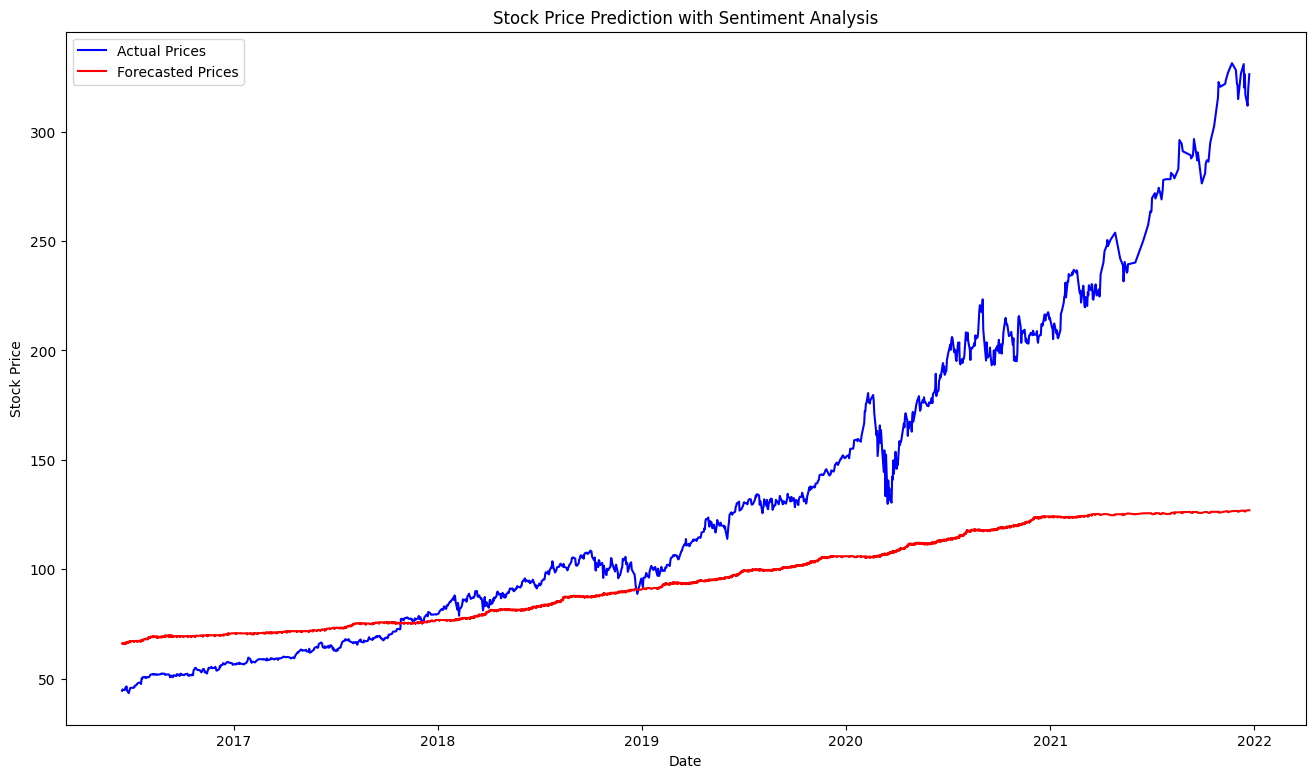

In [21]:
# ------------------------------
# Step 11: Visualization
# ------------------------------

# Plot actual vs predicted stock prices
plt.figure(figsize=(16, 9))
plt.plot(test_data['ds'], actual_prices, label='Actual Prices', color='blue')
plt.plot(test_data['ds'], predicted_prices, label='Forecasted Prices', color='red')
plt.title('Stock Price Prediction with Sentiment Analysis')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

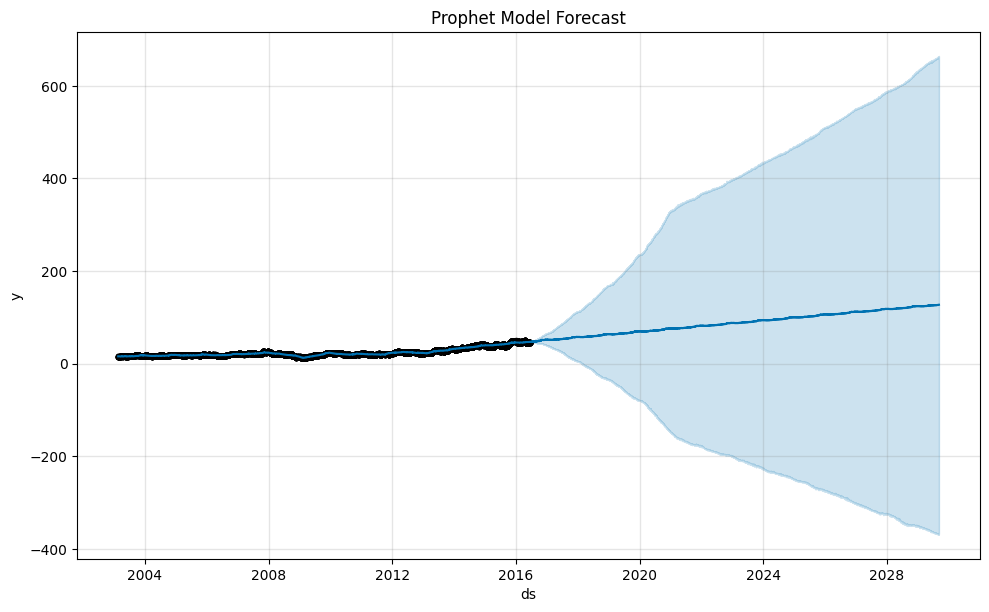

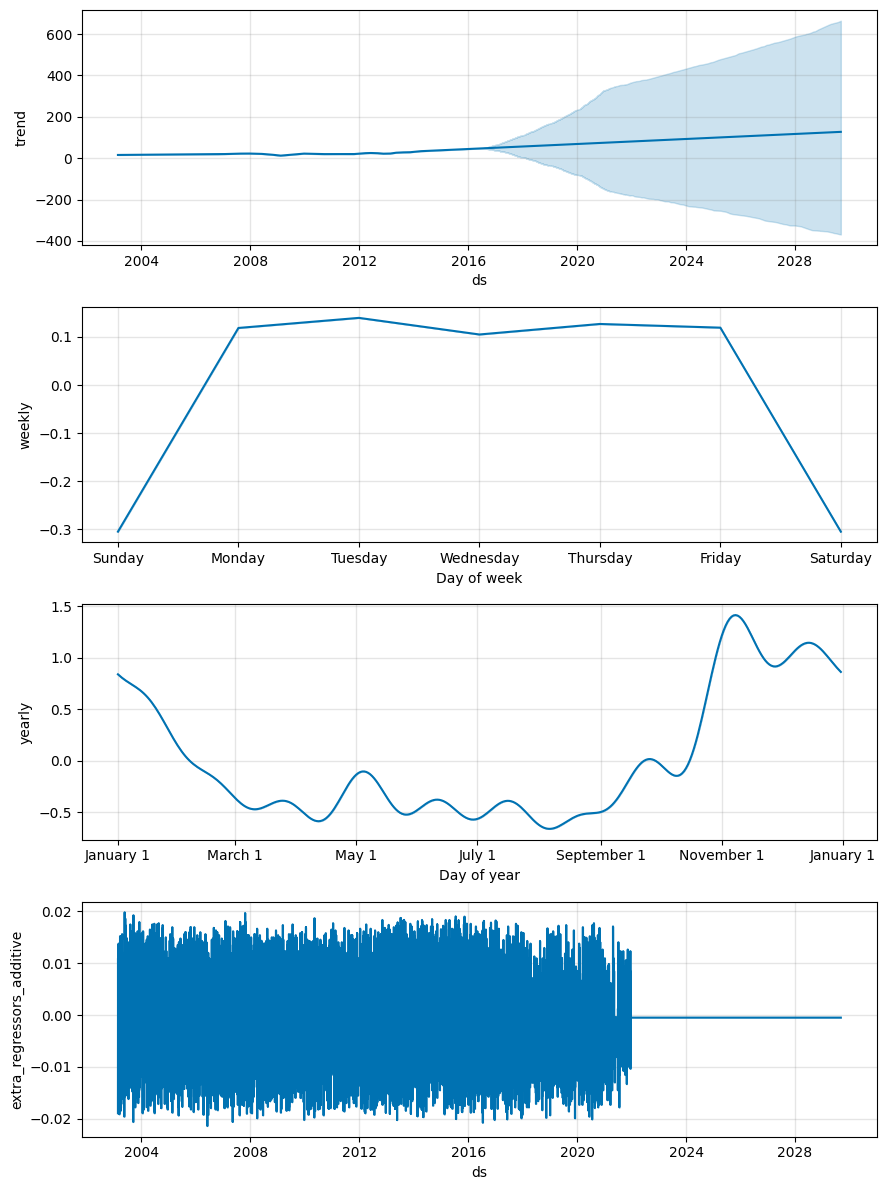

In [22]:
# Visualize the full forecast
fig = model.plot(forecast)
plt.title('Prophet Model Forecast')
plt.show()

# Visualize forecast components
fig = model.plot_components(forecast)
plt.show()

In [23]:
# ------------------------------
# Model Improvement
# Step 1: Merge Stock and News Data
# ------------------------------
merged_data = pd.merge(stock_data_msft, news_data, left_on='Date', right_on='publish_date', how='inner')

# Add lagged sentiment features
merged_data['compound_score_lag1'] = merged_data['compound_score'].shift(1)
merged_data['compound_score_lag2'] = merged_data['compound_score'].shift(2)

# Fill NaN values after lagging
merged_data[['compound_score_lag1', 'compound_score_lag2']] = merged_data[['compound_score_lag1', 'compound_score_lag2']].fillna(0)

In [24]:
# ------------------------------
# Step 2: Feature Scaling (Optional)
# ------------------------------
# Normalize sentiment scores
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
merged_data[['compound_score', 'compound_score_lag1', 'compound_score_lag2']] = scaler.fit_transform(
    merged_data[['compound_score', 'compound_score_lag1', 'compound_score_lag2']]
)

In [25]:
merged_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,publish_date,headline_text,compound_score,positive,neutral,negative,compound_score_lag1,compound_score_lag2
0,2003-02-19,15.322393,15.359433,14.921122,15.143365,46902700,0.08,0.0,2003-02-19,businesses should prepare for terrorist attacks,-2.885944,0.000,0.345,0.655,-0.052959,-0.052959
1,2003-02-19,15.322393,15.359433,14.921122,15.143365,46902700,0.08,0.0,2003-02-19,resource stocks boost all ords,1.331329,0.403,0.597,0.000,-2.885944,-0.052959
2,2003-02-19,15.322393,15.359433,14.921122,15.143365,46902700,0.08,0.0,2003-02-19,shire offers assurances over finances,1.118123,0.375,0.625,0.000,1.331329,-2.885944
3,2003-02-19,15.322393,15.359433,14.921122,15.143365,46902700,0.08,0.0,2003-02-19,slow recovery predicted for aust economy,-0.052959,0.000,1.000,0.000,1.118123,1.331329
4,2003-02-20,15.291526,15.353261,14.877908,14.902601,50897200,0.00,0.0,2003-02-20,mud crab business on the move,-0.052959,0.000,1.000,0.000,-0.052959,1.118123


In [26]:
# ------------------------------
# Step 6: Prepare Data for Prophet
# ------------------------------
prophet_data = merged_data[['Date', 'Close', 'compound_score', 'compound_score_lag1', 'compound_score_lag2']].rename(
    columns={'Date': 'ds', 'Close': 'y'}
)

In [27]:
# Split into train and test
train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data.iloc[:train_size]
test_data = prophet_data.iloc[train_size:]

In [28]:
# ------------------------------
# Step 7: Train the Prophet Model
# ------------------------------
# Define the Prophet model with multiplicative seasonality
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.05)

# Add sentiment and lagged features as regressors
model.add_regressor('compound_score')
model.add_regressor('compound_score_lag1')
model.add_regressor('compound_score_lag2')

# Fit the model on training data
model.fit(train_data)

13:39:11 - cmdstanpy - INFO - Chain [1] start processing
13:39:40 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# ------------------------------
# Step 8: Forecasting
# ------------------------------
# Create future dataframe
future = model.make_future_dataframe(periods=len(test_data))
future = pd.merge(
    future, 
    prophet_data[['ds', 'compound_score', 'compound_score_lag1', 'compound_score_lag2']], 
    on='ds', 
    how='left'
)

In [32]:
future['compound_score'] = future['compound_score'].ffill().fillna(0)
future['compound_score_lag1'] = future['compound_score_lag1'].ffill().fillna(0)
future['compound_score_lag2'] = future['compound_score_lag2'].ffill().fillna(0)

# Forecast using the model
forecast = model.predict(future)

In [33]:
# ------------------------------
# Step 9: Evaluation
# ------------------------------

# Extract forecasted values for the test period
forecast_test = forecast.iloc[-len(test_data):]
actual_test = test_data['y'].values

In [34]:
# Calculate evaluation metrics
mse = mean_squared_error(actual_test, forecast_test['yhat'])
mae = mean_absolute_error(actual_test, forecast_test['yhat'])

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 16106.882359397241
Mean Absolute Error (MAE): 78.42093270755461


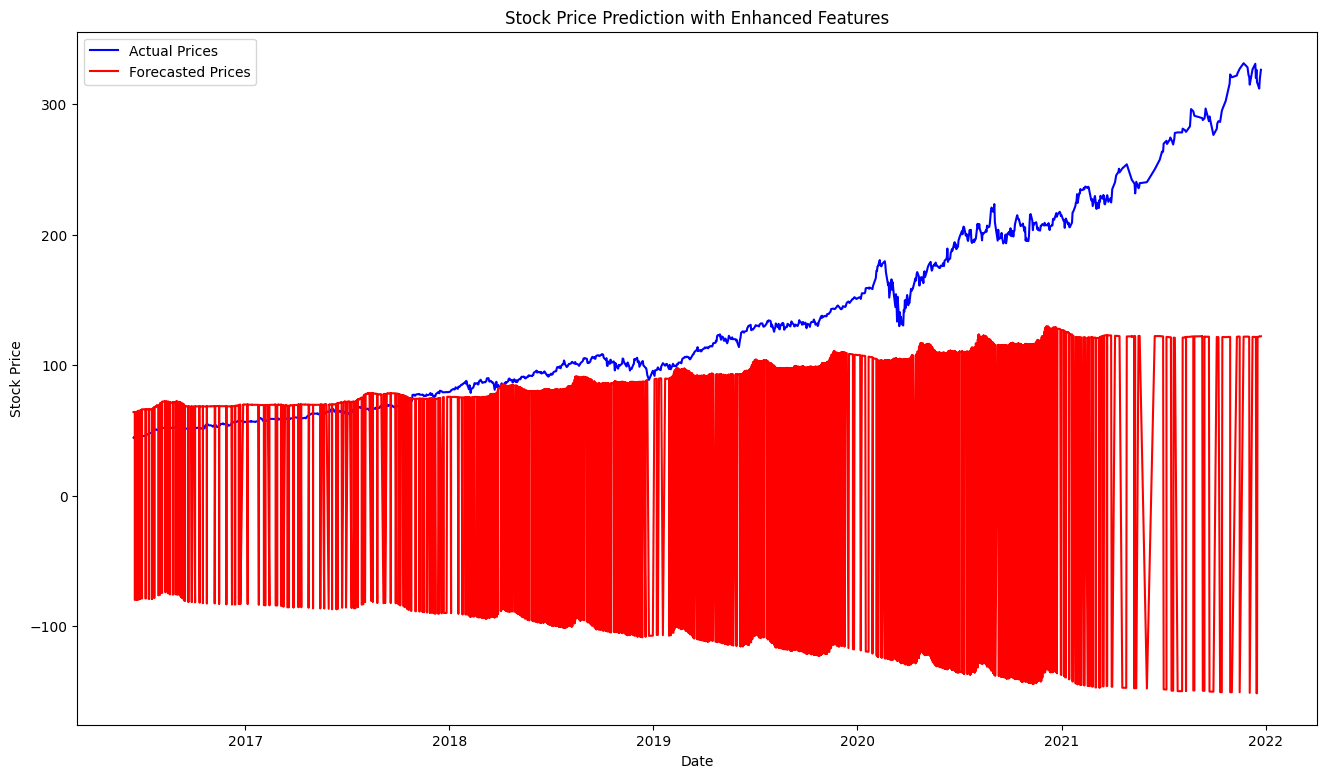

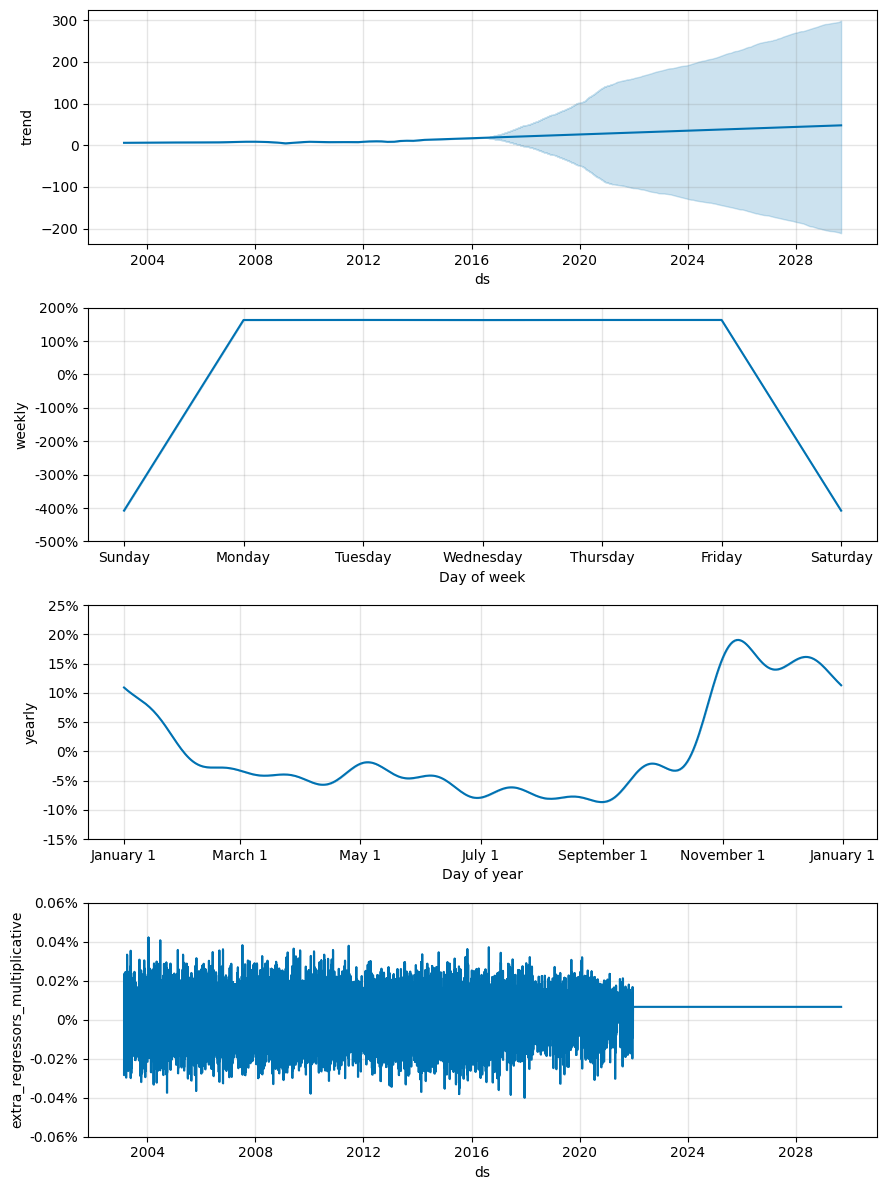

In [36]:
# ------------------------------
# Step 10: Visualization
# ------------------------------

# Plot actual vs. forecasted stock prices
plt.figure(figsize=(16, 9))
plt.plot(test_data['ds'], actual_test, label='Actual Prices', color='blue')
plt.plot(test_data['ds'], forecast_test['yhat'], label='Forecasted Prices', color='red')
plt.title("Stock Price Prediction with Enhanced Features")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Plot the trend and components
model.plot_components(forecast)
plt.show()

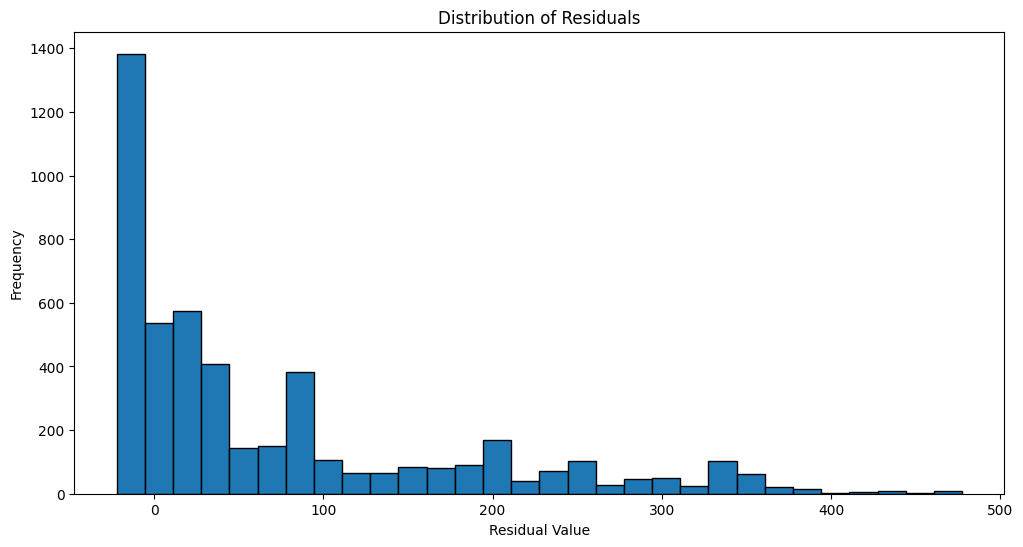

In [37]:
# Residual Analysis
residuals = actual_test - forecast_test['yhat']
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor="black")
plt.title("Distribution of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()

In [38]:
# Display the forecast data for further inspection
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

              ds        yhat  yhat_lower  yhat_upper
27740 2029-08-29  121.560699 -535.148219  759.268127
27741 2029-08-30  121.644657 -537.210494  760.176404
27742 2029-08-31  121.666137 -538.448923  758.712361
27743 2029-09-01 -151.226594 -944.438409  667.314728
27744 2029-09-02 -151.230472 -944.700392  669.117662
27745 2029-09-03  121.684016 -535.261600  759.525693
27746 2029-09-04  121.832089 -537.232848  761.866303
27747 2029-09-05  121.804194 -537.703947  759.995200
27748 2029-09-06  122.006520 -539.420562  765.123845
27749 2029-09-07  122.154354 -539.052915  763.586342
